In [1]:
import numpy as np
import math 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Normalization # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Input, Embedding , Flatten, Concatenate # type: ignore
from keras.models import Model # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.layers import Dense, Dropout, Activation , BatchNormalization , Dot # type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from wordcloud import WordCloud
from scipy.sparse.linalg import svds
from IPython.display import SVG


2024-11-12 22:45:33.119325: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 22:45:33.122476: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 22:45:33.130603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731431733.144240  492547 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731431733.147923  492547 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 22:45:33.162677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Data visualisation

In [2]:
#gathering data from the dataset

movies = pd.read_csv('dataset/movies.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
movies.columns = ['movie_id' , 'title' , 'genres']

ratings = pd.read_csv('dataset/ratings.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
ratings.columns = ['user_id' , 'movie_id' , 'rating' , 'timestamp']

users = pd.read_csv('dataset/users.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
users.columns = ['user_id','gender','age','occupation','zip_code']

In [3]:
print(movies.shape , ratings.shape , users.shape)
movies.head()

(3883, 3) (1000209, 4) (6040, 5)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(movies.isnull().sum())  # Check for missing values in movies DataFrame
print(ratings.isnull().sum())  # Check for missing values in ratings DataFrame
print(users.isnull().sum())  # Check for missing values in users DataFrame

movie_id    0
title       0
genres      0
dtype: int64
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64


In [5]:
print(ratings.duplicated().sum())  # Check for duplicate rating records
print(movies.duplicated().sum())   # Check for duplicate movie records
print(users.duplicated().sum())    # Check for duplicate user records

0
0
0


In [6]:
def extract_year(movie_name):
    try:
        start = movie_name.rindex('(')
        end = movie_name.rindex(')')
        year = int(movie_name[start + 1:end])
        return year
    except (ValueError, IndexError):
        return None

In [7]:
def prepare_years(train_data , max_genres = 5):
    
    title = train_data['title']
    years = [extract_year(name) for name in title]
    
    return (   
        years
    )    

In [8]:
#merging the dataframes movies and ratings on the basis of movie_id aggregate the ratings of each movie
movie_ratings = pd.merge(movies , ratings , on='movie_id')
movie_ratings_mean = movie_ratings.groupby('title').agg({'rating':[np.size,np.mean]})
movie_ratings.head()

,movie_id,title,genres,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [9]:
years = prepare_years(movie_ratings)

movie_ratings = pd.merge(movie_ratings , pd.DataFrame(years , columns=['year']) , left_index=True , right_index=True)
print(movie_ratings.shape)

(1000209, 7)


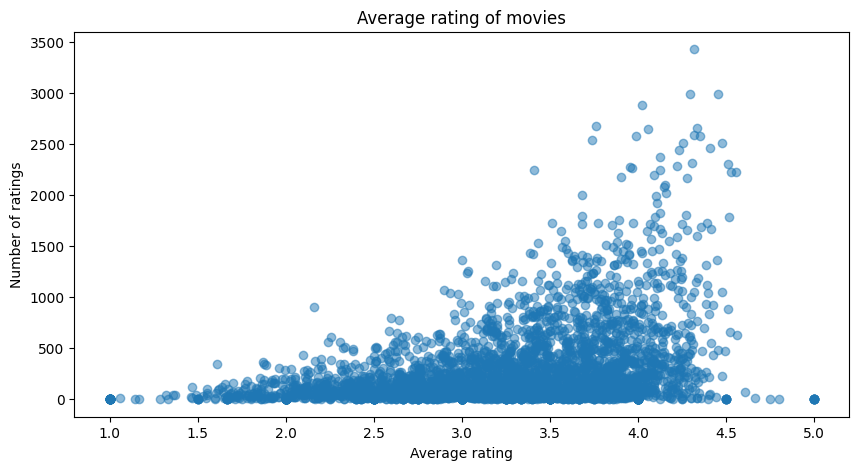

In [10]:
#plot the average rating scatter plot
plt.figure(figsize=(10,5))
plt.title('Average rating of movies')
plt.scatter(movie_ratings_mean[('rating','mean')] , movie_ratings_mean[('rating','size')] , alpha=0.5)
plt.xlabel('Average rating')
plt.ylabel('Number of ratings')
plt.show()


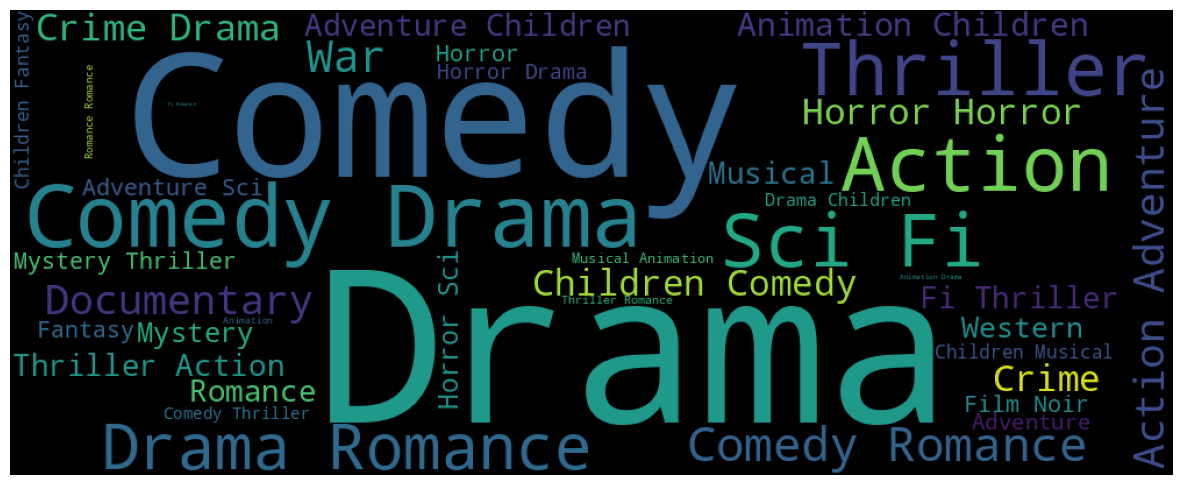

In [11]:
#show the relationship between the average rating and genre
genres = set()
for genre in movies.genres.str.split('|').values:
    genres = genres.union(set(genre))
genres = list(genres)

#display wordcloud of genres
genre_wordcloud = WordCloud(width=1000,height=400).generate(' '.join(movies['genres']))
plt.figure(figsize=(15,10))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

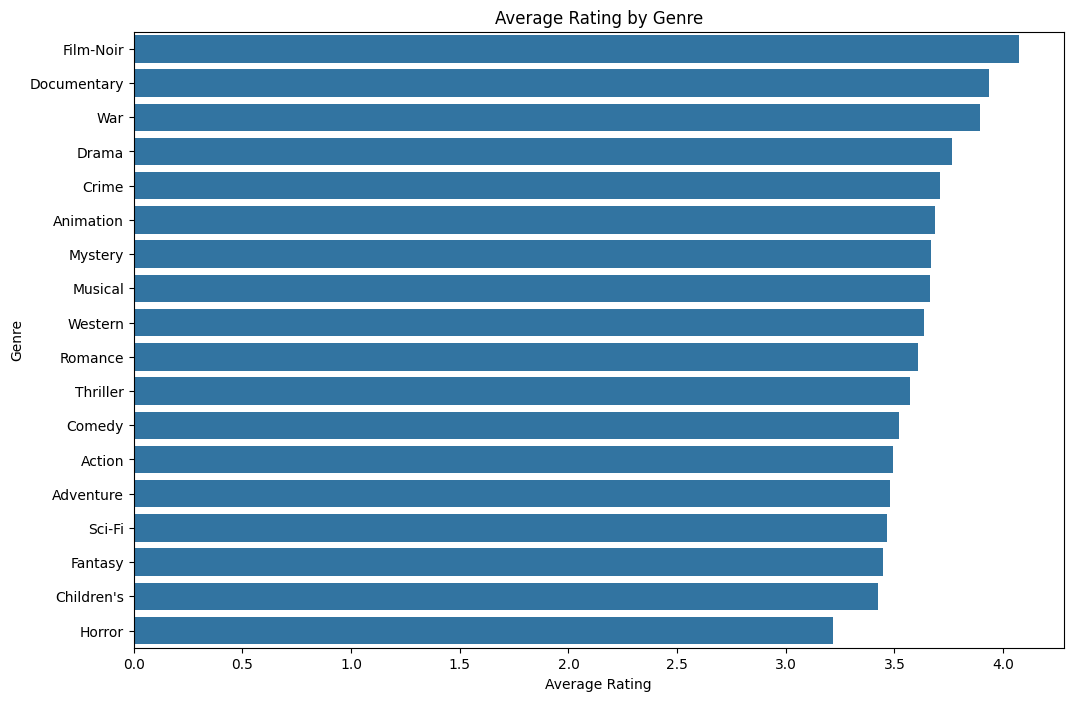

In [12]:
#merge movies and ratings dataframes on the basis of genre and aggregate the ratings of each genre

movies_exploded = movies.copy()
movies_exploded['genre'] = movies_exploded['genres'].str.split('|')
movies_exploded = movies_exploded.explode('genre')

# Step 3: Merge with ratings DataFrame on movieId
merged_data = pd.merge(movies_exploded[['movie_id', 'genre']], ratings[['movie_id', 'rating']], on='movie_id')

# Step 4: Calculate the average rating for each genre
genre_ratings = merged_data.groupby('genre')['rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'average_rating']

genre_ratings_sorted = genre_ratings.sort_values(by='average_rating', ascending=False)

# Display the average rating per genre in a bar chart top to bottom sorted
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='genre', data=genre_ratings_sorted)
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating by Genre')
plt.show()


## Data Preprocessing

In [13]:
#use Label encoding to encode the genres
MoviesWithGenres = movies.copy()
for genre in genres :
  MoviesWithGenres[genre] = MoviesWithGenres.apply(lambda _:int(genre in _.genres), axis = 1)
MoviesWithGenres.head()

,movie_id,title,genres,Adventure,Comedy,Sci-Fi,Mystery,Animation,Documentary,Romance,...,War,Western,Horror,Crime,Children's,Action,Musical,Film-Noir,Thriller,Drama
0,1,Toy Story (1995),Animation|Children's|Comedy,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
newratedmovies = movie_ratings.copy()

newratedmovies.userId = newratedmovies.user_id.astype('category').cat.codes.values
newratedmovies.movieId = newratedmovies.movie_id.astype('category').cat.codes.values
newratedmovies.genres = newratedmovies.genres.astype('category').cat.codes.values

newratedmovies.head()

,movie_id,title,genres,user_id,rating,timestamp,year
0,1,Toy Story (1995),145,1,5,978824268,1995
1,1,Toy Story (1995),145,6,4,978237008,1995
2,1,Toy Story (1995),145,8,4,978233496,1995
3,1,Toy Story (1995),145,9,5,978225952,1995
4,1,Toy Story (1995),145,10,5,978226474,1995


In [15]:

train_data, test_data = train_test_split(newratedmovies, test_size=0.2, random_state=42)
train_data.head()


,movie_id,title,genres,user_id,rating,timestamp,year
416292,1405,Beavis and Butt-head Do America (1996),154,4375,4,965179742,1996
683230,2527,Westworld (1973),89,2254,4,974594425,1973
2434,2,Jumanji (1995),115,3202,2,968575400,1995
688533,2542,"Lock, Stock & Two Smoking Barrels (1998)",183,710,4,979018202,1998
472584,1676,Starship Troopers (1997),36,4953,2,962641436,1997


## Matrix Factorisation 

In [16]:
def create_model(num_users, num_movies, num_genres, embedding_dim=5):
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    genre_input = Input(shape=(1,), name='genre_input')  # Genre input
    year_input = Input(shape=(1,), name='year_input')  # Release year input

    # User embedding
    user_embedding = Embedding(
        input_dim=num_users,
        output_dim=embedding_dim,
        embeddings_initializer='he_normal',
        name='user_embedding'
    )(user_input)
    user_vector = Flatten()(user_embedding)


    # Movie embedding
    movie_embedding = Embedding(
        input_dim=num_movies,
        output_dim= embedding_dim,
        embeddings_initializer='he_normal',
        name='movie_embedding'
    )(movie_input)
    movie_vector = Flatten()(movie_embedding)


    # Genre embedding
    genre_embedding = Embedding(
        input_dim=num_genres + 1,
        output_dim=embedding_dim ,
        embeddings_initializer='he_normal',
        name='genre_embedding',
        mask_zero=True
    )(genre_input)
    genre_vector = Flatten()(genre_embedding)

    concat = Concatenate()([
        user_vector,
        movie_vector,
        genre_vector,
    ])

    # Dense layers
    x = Dense(100, activation='relu')(concat)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(50, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(20, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(1, activation='relu')(x)

    # Create model
    model = Model(
        inputs=[user_input, movie_input, genre_input],
        outputs=output
    )

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mean_squared_error',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

In [17]:
#find the number of unique users, movies and genres

num_users = max(users['user_id'])+1
num_movies = max(movies['movie_id'])+1
num_genres = max(newratedmovies['genres'])+1


print(num_users, num_movies, num_genres)

# Create model
model = create_model(num_users, num_movies, num_genres, embedding_dim=20)

6041 3953 301


W0000 00:00:1731431742.016655  492547 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 20)     │    120,820 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 20)     │     79,060 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_embedding     │ (None, 1, 20)     │      6,040 │ genre_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ genre_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │      6,100 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100)       │        400 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      5,050 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │      1,020 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 218,791 (854.65 KB)

 Trainable params: 218,451 (853.32 KB)

 Non-trainable params: 340 (1.33 KB)

In [19]:
# Prepare data
user_ids = train_data['user_id']
movie_ids = train_data['movie_id']
ratings = train_data['rating']
genres_list = train_data['genres']
years_list = train_data['year']


In [20]:
callbacks = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True)]


history = model.fit(
    x=[user_ids, movie_ids, genres_list],
    y=ratings,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    validation_data=([test_data['user_id'], test_data['movie_id'], test_data['genres']], test_data['rating']),
    callbacks=callbacks
)

Epoch 1/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 1.4061 - mae: 0.9027 - rmse: 1.1595 - val_loss: 0.8367 - val_mae: 0.7291 - val_rmse: 0.9147
Epoch 2/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.8443 - mae: 0.7282 - rmse: 0.9189 - val_loss: 0.8070 - val_mae: 0.7142 - val_rmse: 0.8983
Epoch 3/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.8104 - mae: 0.7129 - rmse: 0.9002 - val_loss: 0.8024 - val_mae: 0.7138 - val_rmse: 0.8958
Epoch 4/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7851 - mae: 0.7010 - rmse: 0.8860 - val_loss: 0.7770 - val_mae: 0.6961 - val_rmse: 0.8815
Epoch 5/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7669 - mae: 0.6924 - rmse: 0.8757 - val_loss: 0.7845 - val_mae: 0.7008 - val_rmse: 0.8857
Epoch 6/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7523 - mae: 0.6856 - rmse: 0.8673 - val_loss: 0.7658 - val_mae: 0.6937 - val_rmse: 0.8751
Epoch 7/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7402 

In [21]:
#take the input movie from the user and take a random user from the dataset that has rated the movie
def get_user(movie_id):
    user = newratedmovies[newratedmovies['movie_id'] == movie_id]
    print(user)
    return user['user_id'].values[0]

def get_movie_id(movie_name):
    movie = movies[movies['title'] == movie_name]
    return movie['movie_id'].values[0]
    

In [22]:
def predict_rating(user_id , movie_id):
    user = np.array([user_id])
    movie = np.array([movie_id])
    genre = np.array([newratedmovies[newratedmovies['movie_id'] == movie_id]['genres'].values[0]])
    prediction = model.predict([user, movie, genre])
    return prediction[0][0]

In [29]:
# Load the model weights
model = create_model(num_users, num_movies, num_genres, embedding_dim=20)
model.load_weights('best_model.weights.h5')

# Get the movie ID for the given movie name
movie_name = 'Grumpier Old Men (1995)'
movie_id = get_movie_id(movie_name)

# Get the user who rated the movie
user_id = get_user(movie_id)

# Get the genres of the specified movie
movie_genres = movies[movies['movie_id'] == movie_id]['genres'].values[0].split('|')  # Assuming genres are "|" separated

# Retrieve user ratings and predict ratings for rated movies
user_ratings = newratedmovies[newratedmovies['user_id'] == user_id][['user_id', 'movie_id', 'rating']]
user_ratings['predicted_rating'] = user_ratings.apply(lambda x: predict_rating(user_id, x['movie_id']), axis=1)
user_ratings = user_ratings.sort_values(by='rating', ascending=False).merge(movies, on='movie_id', how='inner', suffixes=['_u', '_m']).head(20)


# Get movie recommendations
recommended_movies = newratedmovies[newratedmovies['movie_id'].isin(user_ratings['movie_id'])]['movie_id'].unique()
recommendations = pd.DataFrame(recommended_movies, columns=['movie_id'])
recommendations['predictions'] = recommendations.apply(lambda x: predict_rating(user_id, x['movie_id']), axis=1)



# # Filter recommendations by genre similarity
recommendations = recommendations.merge(movies[['movie_id', 'genres']], on='movie_id', how='inner')
recommendations['genre_match'] = recommendations['genres'].apply(lambda g: len(set(g.split('|')) & set(movie_genres)))

# # Sort by genre match (prioritized) and then by prediction score
recommendations = recommendations.sort_values(by=['genre_match', 'predictions'], ascending=[False, False])

# # Display the top 10 recommendations
top_recommendations = recommendations.merge(movies, on='movie_id', how='inner', suffixes=['_u', '_m']).head(10)
top_recommendations[['movie_id', 'title']]



      movie_id                    title  genres  user_id  rating   timestamp  \
2778         3  Grumpier Old Men (1995)     207       26       2   978140022   
2779         3  Grumpier Old Men (1995)     207       45       2   977989159   
2780         3  Grumpier Old Men (1995)     207       62       3   977904968   
2781         3  Grumpier Old Men (1995)     207      137       5  1000869657   
2782         3  Grumpier Old Men (1995)     207      153       5   977437594   
...        ...                      ...     ...      ...     ...         ...   
3251         3  Grumpier Old Men (1995)     207     5972       3   976205350   
3252         3  Grumpier Old Men (1995)     207     6000       3   956885279   
3253         3  Grumpier Old Men (1995)     207     6016       2   956785966   
3254         3  Grumpier Old Men (1995)     207     6025       3   956731760   
3255         3  Grumpier Old Men (1995)     207     6035       1   956713372   

      year  
2778  1995  
2779  1995  


,movie_id,title
0,356,Forrest Gump (1994)
1,2262,About Last Night... (1986)
2,2243,Broadcast News (1987)
3,118,If Lucy Fell (1996)
4,499,Mr. Wonderful (1993)
5,1784,As Good As It Gets (1997)
6,2352,"Big Chill, The (1983)"
7,2020,Dangerous Liaisons (1988)
8,3543,Diner (1982)
9,2146,St. Elmo's Fire (1985)


In [30]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 19 = 0.8671


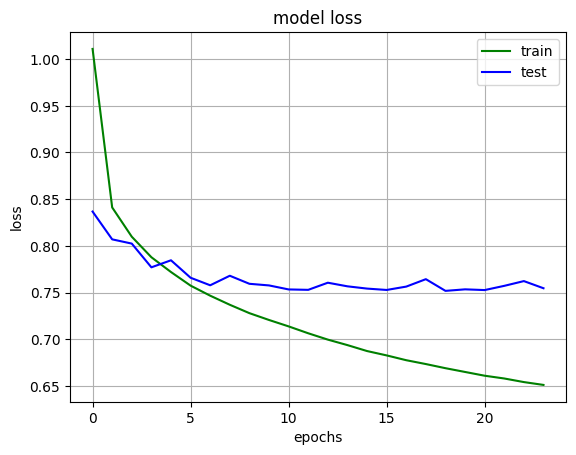

In [31]:
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()